

<span style="font-size:2.4em;">Notebook 4: County Residual Analysis (All Models)</span>


This notebook evaluates the county-level errors (residuals) in overdose rate predictions from our baseline, random forest, and LSTM models. 

Lucy Herr
<br>  3/17/24
<br>  UCB MIDS Capstone Spring 2024

# Import libraries and model results

In [430]:
import pandas as pd
import numpy as np 

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# descaling lstm results
from sklearn.preprocessing import RobustScaler

# mapping libraries
import requests
import json
import folium 

In [411]:
# naive model data & residuals 
naive_res = pd.read_csv("model_output/Naive_out.csv")

# scalecast lstm model data & residuals 
lstm_res = pd.read_csv("model_output/lstm_4layer_2lag_res.csv")

# random forest model data & residuals 
rf_res = pd.read_csv("model_output/Random_Forest_Output.csv")

# # lstm raw (pre-transformation) input data
lstm_raw = pd.read_csv('raw_data/full_with_age_pcts_LSTM.csv')

# CA county boundaries for mapping 
#Source: https://gis.data.ca.gov/datasets/8713ced9b78a4abb97dc130a691a8695/explore
with open('raw_data/California_County_Boundaries_5206538824092848308.geojson', 'r') as file:
    ca_geojson = json.load(file)

# county_geo = requests.get(
#     'https://public.opendatasoft.com/explore/dataset/georef-united-states-of-america-county/api/?flg=en-us&disjunctive.ste_code&disjunctive.ste_name&disjunctive.coty_code&disjunctive.coty_name&refine.ste_name=California'
# ).json()

# Format LSTM results for analysis

In [412]:
# remove unnecessary columns 
lstm_res.drop(['Unnamed: 0','DATE'],axis=1,inplace=True)

# undo OHE (convert encoded county cols back to single col)
prefix = "county_name_"
county_ohe_cols = [c for c in lstm_res.columns if c.startswith(prefix)]
cat_series = lstm_res[county_ohe_cols].idxmax(axis=1)

#strip prefix 
cat_series = cat_series.apply(lambda x: x[len(prefix):])
lstm_res_temp = lstm_res.drop(columns=county_ohe_cols)
lstm_res = pd.concat([lstm_res_temp, cat_series.rename('county_name')], axis=1)

# #['county_all_drugs_monthly_rate'] ~ actuals, cut last few observations for same shape as res df
# lstm_trainval_target = lstm_trainval.iloc[:4405,69].to_frame()
# lstm_trainval_target['c2'] = lstm_trainval_target['county_all_drugs_monthly_rate']
# lstm_trainval_target['c3'] = lstm_trainval_target['county_all_drugs_monthly_rate']

# # refit scaler on lstm trainval target column (pre-scaling) to inverse transform residuals 
# rscaler = RobustScaler().fit(lstm_trainval_target)
# inverse_scale_cols = ['Actuals','FittedVals','Residuals']
# lstm_res_temp = rscaler.inverse_transform(lstm_res[inverse_scale_cols])

# # create df of de-scaled data 
# lstm_res_inv = pd.DataFrame({'Actuals_inv': lstm_res_temp[:, 0],
#                              'FittedVals_inv': lstm_res_temp[:, 1],
#                              'Residuals_inv': lstm_res_temp[:, 2]})
# add to main lstm results 
# lstm_res = pd.concat([lstm_res,lstm_res_inv], axis = 1)


In [413]:
lstm_raw.shape

(5568, 139)

In [414]:
# align period date format to filter corresponding raw values in original data 
lstm_raw['period'] = pd.to_datetime(lstm_raw['period'],format = '%Y%m')
lstm_res['period'] = pd.to_datetime(lstm_res['period'],format = '%Y-%m')
lstm_periods = lstm_trainval.period.unique()#.to_list()
lstm_periods = [col for col in lstm_periods]
lstm_raw = lstm_raw[lstm_raw['period'].isin(lstm_periods)]
lstm_raw.shape

(4408, 139)

In [323]:
#lstm_raw = lstm_raw.sort_values(by='period') 
lstm_raw.head()

,county_fips,county_name,state,month_date,period,year,month,quarter,Overdose_Rate_X100K,county_all_drugs_death_count,...,7074_PCT_MALE,7074_PCT_FEM,7579_PCT_MALE,7579_PCT_FEM,8084_PCT_MALE,8084_PCT_FEM,85PLUS_PCT_MALE,85PLUS_PCT_FEM,MEDIAN__PCT_MALE,MEDIAN__PCT_FEM
1,6001,ALAMEDA,CA,2/1/2016,2016-02-01,2016,2,1,0.969307,13,...,1.405833,1.676314,0.925631,1.17703,0.625831,0.880561,0.624256,1.160916,0.002211,0.002314
2,6001,ALAMEDA,CA,3/1/2016,2016-03-01,2016,3,1,1.342118,18,...,1.405833,1.676314,0.925631,1.17703,0.625831,0.880561,0.624256,1.160916,0.002211,0.002314
3,6001,ALAMEDA,CA,4/1/2016,2016-04-01,2016,4,2,1.118431,15,...,1.405833,1.676314,0.925631,1.17703,0.625831,0.880561,0.624256,1.160916,0.002211,0.002314
4,6001,ALAMEDA,CA,5/1/2016,2016-05-01,2016,5,2,1.267556,17,...,1.405833,1.676314,0.925631,1.17703,0.625831,0.880561,0.624256,1.160916,0.002211,0.002314
5,6001,ALAMEDA,CA,6/1/2016,2016-06-01,2016,6,2,0.969307,13,...,1.405833,1.676314,0.925631,1.17703,0.625831,0.880561,0.624256,1.160916,0.002211,0.002314


In [415]:
# align county name column in raw data to prep for join
lstm_raw['county_name'] = lstm_raw['county_name'].str.title()

# select only relevant columns
select_cols = ['period','county_name','county_all_drugs_monthly_rate','county_all_drugs_death_count',]
lstm_raw = lstm_raw[select_cols]

# merge raw data columns 
lstm_res = lstm_res.merge(lstm_raw,left_on=['period','county_name'], right_on=['period','county_name'], how='left')

In [418]:
lstm_res.describe()

,Actuals,FittedVals,Residuals,Actuals_inv,FittedVals_inv,Residuals_inv,county_all_drugs_monthly_rate,county_all_drugs_death_count
count,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000
mean,0.743359,0.186277,0.557083,0.739375,0.182378,0.553127,3.608557,11.359137
std,3.666517,0.044721,3.666815,3.665950,0.044714,3.666248,10.127280,22.164421
min,-0.587441,-0.346510,-2.413411,-0.591220,-0.350326,-2.416907,0.000000,0.000000
25%,-0.426940,0.185417,-0.612455,-0.430744,0.181519,-0.616230,0.498499,5.000000
50%,0.000116,0.185486,-0.189704,-0.003754,0.181587,-0.193545,1.532816,5.000000
75%,0.572905,0.185520,0.387517,0.568947,0.181622,0.383588,3.048381,11.000000
max,156.928802,2.765315,156.743252,156.900675,2.761018,156.715154,435.161010,246.000000


In [419]:
lstm_res.drop(['FittedVals_inv','Residuals_inv','Actuals_inv'], axis=1,inplace=True)

# create df of raw rate data with same dimeniosn tp re-fit scaler 
lstm_temp= lstm_res[['county_all_drugs_monthly_rate',
                     'county_all_drugs_monthly_rate',
                     'county_all_drugs_monthly_rate']]
# refit on original rate data 
rscaler = RobustScaler().fit(lstm_temp)

# transform 
inverse_scale_cols = ['Actuals','FittedVals','Residuals']
lstm_res_temp = rscaler.inverse_transform(lstm_res[inverse_scale_cols])

lstm_res_inv = pd.DataFrame({'Actuals_inv': lstm_res_temp[:, 0],
                             'FittedVals_inv': lstm_res_temp[:, 1],
                             'Residuals_inv': lstm_res_temp[:, 2]})

lstm_res = pd.concat([lstm_res,lstm_res_inv], axis = 1)

In [351]:
lstm_res.describe()

,Actuals,FittedVals,Residuals,county_all_drugs_monthly_rate,county_all_drugs_death_count,Actuals_inv,FittedVals_inv,Residuals_inv
count,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000,4405.000000
mean,0.743359,0.186277,0.557083,3.608557,11.359137,3.428296,2.007800,2.953312
std,3.666517,0.044721,3.666815,10.127280,22.164421,9.349187,0.114033,9.349947
min,-0.587441,-0.346510,-2.413411,0.000000,0.000000,0.034911,0.649257,-4.621098
25%,-0.426940,0.185417,-0.612455,0.498499,5.000000,0.444169,2.005608,-0.028873
50%,0.000116,0.185486,-0.189704,1.532816,5.000000,1.533112,2.005784,1.049092
75%,0.572905,0.185520,0.387517,3.048381,11.000000,2.993658,2.005871,2.520940
max,156.928802,2.765315,156.743252,435.161010,246.000000,401.682850,8.584045,401.209720


In [ ]:
# write modified results to file
lstm_res.to_csv('model_output/lstm_res_with_descaled.csv')

# Naive baseline results

In [338]:
naive_res.shape

(174, 7)

In [10]:
naive_res.head()

,unique_id,ds,y,Naive,Naive-lo-95,Naive-hi-95,rmse
0,ALAMEDA,2022-10-01,1.642088,1.824542,0.985912,2.663172,0.033290
1,ALAMEDA,2022-11-01,1.277180,1.824542,0.638540,3.010544,0.299606
2,ALAMEDA,2022-12-01,1.702906,1.824542,0.371993,3.277092,0.014795
3,ALPINE,2022-10-01,0.000000,0.000000,-134.855320,134.855320,0.000000
4,ALPINE,2022-11-01,0.000000,0.000000,-190.714220,190.714220,0.000000


In [63]:
naive_res['diff'] = naive_res['Naive']-naive_res['y']

In [65]:
mean_err_by_cty_naive = naive_res.groupby(['unique_id'])['diff'].mean().reset_index()
mean_err_by_cty_naive = mean_err_by_cty_naive.sort_values(by='diff')

In [390]:
mean_err_by_cty_naive['unique_id'] = mean_err_by_cty_naive['unique_id'].str.title()

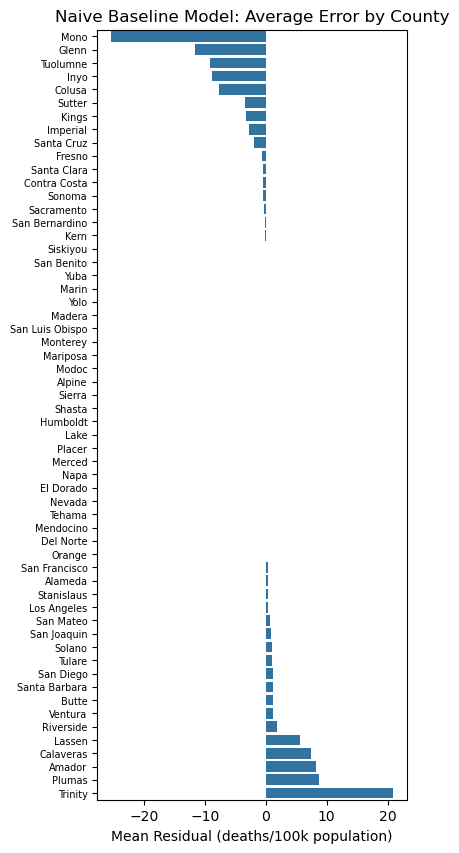

In [428]:
fig,ax = plt.subplots(figsize=(4,10)) 
sns.barplot(x='diff',y='unique_id',data=mean_err_by_cty_naive)
plt.tick_params(axis='y', labelsize=7)  
ax.set_xlabel('Mean Residual (deaths/100k population)', size=10)
ax.set_ylabel('') 
plt.title('Naive Baseline Model: Average Error by County')
plt.show()

In [107]:
naive_res.ds.unique()
[202211, 202212]

array(['2022-10-01', '2022-11-01', '2022-12-01'], dtype=object)

In [110]:
3/len(lstm_res.period.unique())

0.039473684210526314

# Random Forest Results

<Axes: >

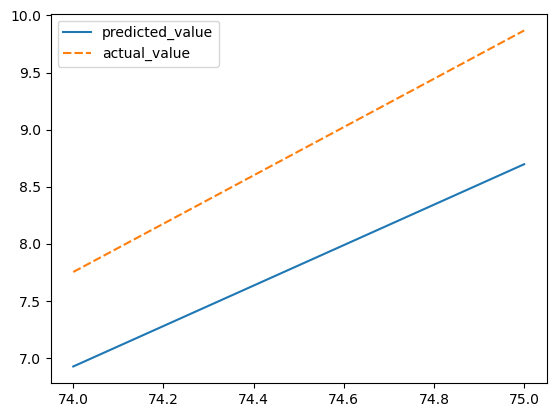

In [431]:
rf_res_sf = rf_res[rf_res['county_name']=='SAN FRANCISCO']
sns.lineplot(data=rf_res_sf[['predicted_value','actual_value']])

# LSTM v1 Results

In [30]:
lstm_res.shape

(4405, 63)

In [371]:
# lstm_res['Abs_Residuals'] = lstm_res['Residuals'].abs()


# mean_err_by_cty_lstm = lstm_res.groupby(['county_name'])['Abs_Residuals'].mean().reset_index()
# mean_err_by_cty_lstm = mean_err_by_cty_lstm.sort_values(by='Abs_Residuals')

# fig,ax = plt.subplots(figsize=(6,10)) 
# sns.barplot(x='Abs_Residuals',y='county_name',data=mean_err_by_cty_lstm)
# #plt.xticks(rotation=90)
# plt.tick_params(axis='y', labelsize=7)  
# ax.set_ylabel('County', size=12) 
# # ax.set_ylabel('Average Error', size=12) 
# plt.title('LSTM Model: MAE per County')
# plt.show()

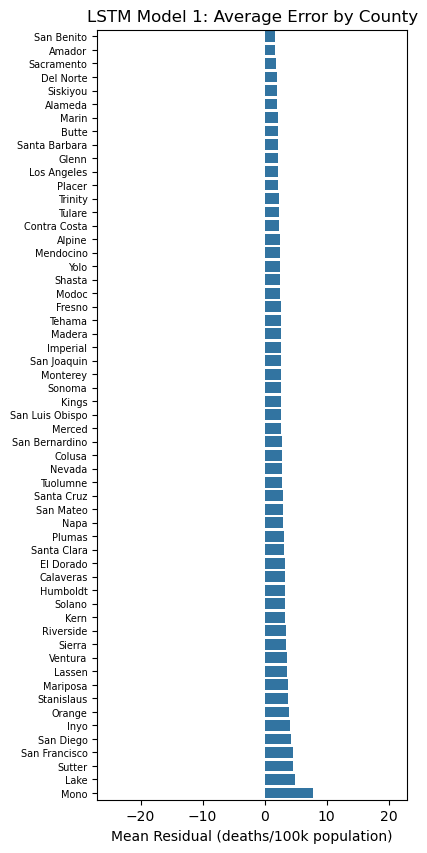

In [426]:
mean_descaled_err_by_cty_lstm = lstm_res.groupby(['county_name'])['Residuals_inv'].mean().reset_index()
mean_descaled_err_by_cty_lstm = mean_descaled_err_by_cty_lstm.sort_values(by='Residuals_inv')

fig,ax = plt.subplots(figsize=(4,10)) 
sns.barplot(x='Residuals_inv',y='county_name',data=mean_descaled_err_by_cty_lstm)
plt.tick_params(axis='y', labelsize=7)  
ax.set_xlabel('Mean Residual (deaths/100k population)', size=10) 
# Get current axis
ax = plt.gca()
# Set the x-axis range to be from 'min_value' to 'max_value'
ax.set_xlim(-27, 23)
ax.set_ylabel('') 
plt.title('LSTM Model 1: Average Error by County')
plt.show()

In [355]:
# RMSE:
rmse = np.sqrt(lstm_res['Residuals_inv'].sum()/lstm_res.shape[0])
rmse

1.718520371784148

In [358]:
mae = abs(lstm_res['Residuals_inv']).sum()/lstm_res.shape[0]
mae 

3.168377094395958

In [84]:
naive_res.ds.unique()

array(['2022-10-01', '2022-11-01', '2022-12-01'], dtype=object)

In [86]:
rf_res.period.unique()

array([202211, 202212])

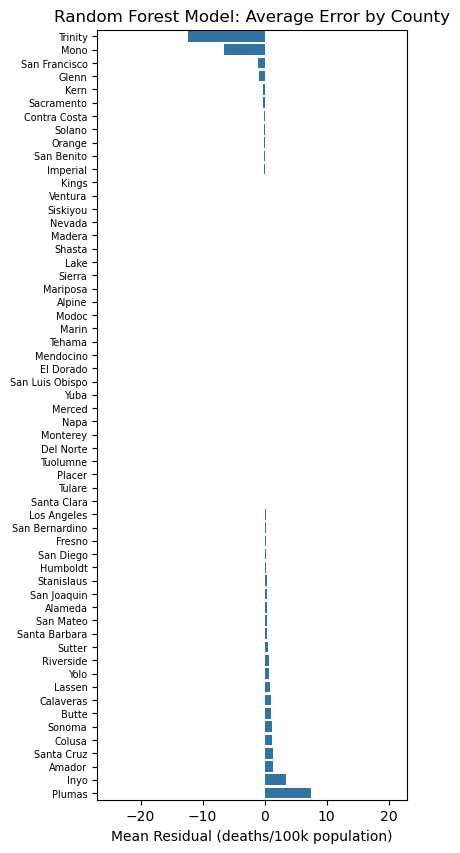

In [429]:
mean_err_by_cty_rf = rf_res.groupby(['county_name'])['difference'].mean().reset_index()
mean_err_by_cty_rf = mean_err_by_cty_rf.sort_values(by='difference')
mean_err_by_cty_rf['county_name']  = mean_err_by_cty_rf['county_name'].str.title()

fig,ax = plt.subplots(figsize=(4,10)) 
sns.barplot(x='difference',y='county_name',data=mean_err_by_cty_rf)
plt.tick_params(axis='y', labelsize=7)  
ax.set_xlabel('Mean Residual (deaths/100k population)', size=10)
# Get current axis
ax = plt.gca()
# Set the x-axis range to be from 'min_value' to 'max_value'
ax.set_xlim(-27, 23)
ax.set_ylabel('') 
plt.title('Random Forest Model: Average Error by County')
plt.show()

# TO DO: Choropleth (heat) maps of mean error by county 

In [ ]:
# Create a base map
m_rf = folium.Map(location=[36.7783, -119.4179], zoom_start=6)

# Add the choropleth layer
folium.Choropleth(
    geo_data=ca_geojson,
    name='choropleth',
    data=mean_err_by_cty_rf,
    columns=['county_name', 'difference'],
    key_on='results.properties.coty_name',  # Adjust based on your GeoJSON properties
    fill_color='YlGn',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='MAE'
).add_to(m_rf)

folium.LayerControl().add_to(m_rf)

In [ ]:
#ca_geojson

# TO DO: Plot error/predicted rate vs. actual rate for select counties over time 
- link to spike analysis